In [1]:
from sympy import *
import sympy
import scipy.integrate
import casadi
from casadi import inf
init_printing()
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


In [2]:
# Define symbols for use with SymPy
# Non-symbolic versions of these (floating point usually)
# are denoted with an underscore before
theta, r, r_pulley, P, theta_max, H = symbols('theta r r_pulley P theta_max H')

# Define parametric equations of winches

def winch1_with_r(r):
    return [r * cos(theta),
            r * sin(theta),
            P * theta]

def winch2_with_r(r):
    return [r * (cos(-theta)),
            r * (sin(-theta)),
            P * (-theta)]

winch2_with_r(Function('r')(theta)) # print out winch2


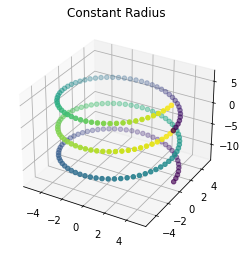

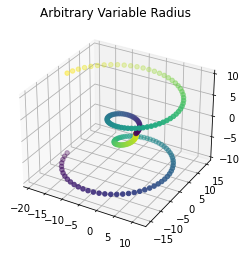

In [3]:
def plot_winch(r_1, theta_now, name, _theta_max=6*np.pi):

    winch1_evaled = [ [winch.evalf(subs={P: 1.0, theta: _theta})
                       for _theta in np.arange(0, theta_now, 0.1)]
                       for winch in winch1_with_r(r_1)]

    winch2_evaled = [ [winch.evalf(subs={P: 1.0, theta: _theta})
                       for _theta in np.arange(0, _theta_max - theta_now, 0.1)]
                       for winch in winch2_with_r(r_1)]

    plt.close(name)
    fig = plt.figure(name)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(name)
    ax.scatter(*winch1_evaled, c=winch1_evaled[2])
    ax.scatter(*winch2_evaled, c=winch2_evaled[2])

# Plot some example winches
plot_winch(5.0, 2*np.pi, 'Constant Radius')
plot_winch((1 + theta + .1*theta**2), 3*np.pi, 'Arbitrary Variable Radius')


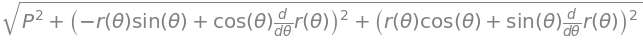

In [4]:
def dL_parametric(parametric_eq):
    # Derivative of the length of a parametric equation (integrate to get length)
    return sqrt(
        Derivative(parametric_eq[0], theta)**2 +
        Derivative(parametric_eq[1], theta)**2 +
        Derivative(parametric_eq[2], theta)**2
    )

# d/dtheta(Lwinch1) for a generalized r function
dL_parametric(winch1_with_r(Function(r)(theta))).doit()

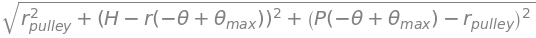

In [5]:
# Define expressions for length of middle cables

def Lmiddle1_with_r(r):
    return sqrt((P*theta - r_pulley)**2 + (H - r)**2 + r_pulley**2)

def Lmiddle2_with_r(r):
    return Lmiddle1_with_r(r).subs(theta, theta_max - theta)

# Lmiddle2 for a generalized r function
Lmiddle2_with_r(Function('r')(theta))

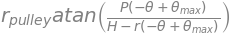

In [6]:
def Larc1_with_r(r):
    return r_pulley * atan(P*theta / (H - r))

def Larc2_with_r(r):
    return Larc1_with_r(r).subs(theta, theta_max - theta)

# Larc2 for a generalized r function
Larc2_with_r(Function('r')(theta))

In [7]:
# Create a polynomial sequence of desired order
order = 3
a = symbols('a:{}'.format(order+1))
R = symbols('R')
R = a[0]
for i in range(1, order+1):
    R += a[i] * theta**i
R


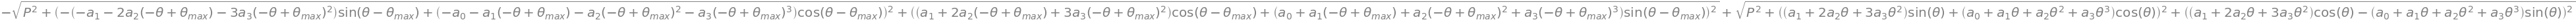

In [8]:
# Create the full winch length derivative equation,
# with the desired R function substituted in before taking the derivative
dLtotalWinch = (dL_parametric(winch1_with_r(R)).doit()
                - dL_parametric(winch2_with_r(R)).doit().subs(theta, theta_max - theta))
dLtotalWinch

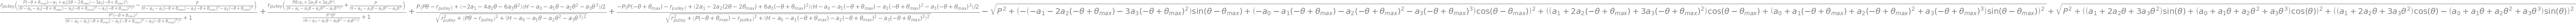

In [9]:
dLtotal = (dLtotalWinch
           + diff(Lmiddle1_with_r(R), theta)
           + diff(Lmiddle2_with_r(R), theta)
           + diff(Larc1_with_r(R), theta)
           + diff(Larc2_with_r(R), theta)
          )
dLlam = lambdify([theta, P, H, theta_max, a], dLtotal)
R_lam = lambdify([a, theta], R, "sympy")
dLtotal


In [10]:
# Modified version from here: https://gist.github.com/jgillis/80bb594a6c8fcf55891d1d88b12b68b8
def sympy2casadi(sympy_expr,sympy_var,casadi_var):
    import casadi
    assert casadi_var.is_vector()
    if casadi_var.shape[1]>1:
        casadi_var = casadi_var.T
    casadi_var = casadi.vertsplit(casadi_var)
    from sympy.utilities.lambdify import lambdify

    mapping = {'ImmutableDenseMatrix': casadi.blockcat,
               'MutableDenseMatrix': casadi.blockcat,
               'Abs':casadi.fabs
              }
    f = lambdify(sympy_var, sympy_expr, modules=[mapping, casadi])
    return f(*casadi_var)


In [11]:
# Formulate the final problem in terms of casadi variables

dtheta = 0.2

# Parameters
_theta_max = 15*np.pi
_P = 1.0
_H = 40.0
_r_pulley = 10.0
min_radius = 5.0
max_radius = 8.0

# somewhat arbitrary starting radius within the allowable range
a_0 = [(min_radius + max_radius) / 2]
# zeros for all other initial values
for i in range(order):
    a_0.append(0)

theta_range = np.arange(0, _theta_max, dtheta)

radius_constraint = []
dLtotal_with_constants = dLtotal.subs({P: _P,
                                       H: _H,
                                       theta_max: _theta_max,
                                       r_pulley: _r_pulley
                                      })

a_casadi = casadi.SX.sym('a', order+1)
theta_casadi = casadi.SX.sym('theta')

# Convert the expressions from sympy variables to casadi variables

dLtotal_casadi = sympy2casadi(dLtotal_with_constants,
                           [theta] + list(a),
                           casadi.vertcat(theta_casadi, a_casadi))

R_casadi = sympy2casadi(R,
                        [theta] + list(a),
                        casadi.vertcat(theta_casadi, a_casadi))

# Create empty vector for objective function
objective_vec = casadi.SX(len(theta_range),1)

# Populate objective vector by substituting in values for theta
# Also create a radius expression for each value of theta
for index, _theta in enumerate(theta_range):
    objective_vec[index] = casadi.substitute(dLtotal_casadi, theta_casadi, _theta)
    radius_constraint.append(casadi.substitute(R_casadi, theta_casadi, _theta))

# Create objective function based on L2 norm of objective vector (least squares)
# The L1 norm takes dramatically longer to converge and sometimes never converges.
objective = casadi.norm_2(objective_vec)


In [12]:
nlp = {'x': a_casadi, 'f': objective, 'g': casadi.vertcat(*radius_constraint)}

S = casadi.nlpsol('S', 'ipopt', nlp)

res = S(x0=a_0,
        lbg=[min_radius]*len(radius_constraint),
        ubg=[max_radius]*len(radius_constraint),
        lbx=[-inf for param in a_0],
        ubx=[+inf for param in a_0]
       )


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      941
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

[ 7.86903898e+00 -1.75934703e-01  3.48261708e-03 -1.80564998e-07]


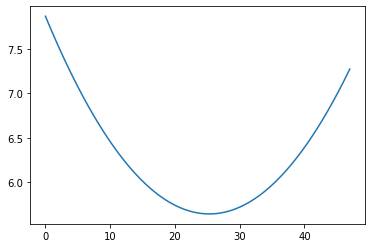

In [13]:
# Convert the result from casadi array to python array and plot
res_x = res['x'].full().T[0]
print(res_x)
plt.close('result_R')
plt.figure('result_R')
R_optimal = lambdify(theta, R_lam(res_x, theta))
x = np.arange(0, _theta_max, dtheta)
R_plt = [R_optimal(theta) for theta in x]
plt.plot(x, R_plt)


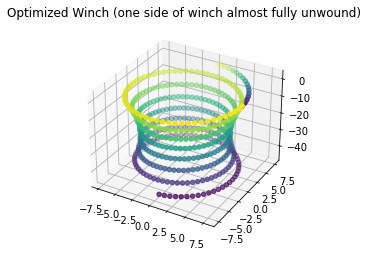

In [14]:
plot_winch(R_lam(res_x, theta), .5*np.pi,
           'Optimized Winch (one side of winch almost fully unwound)',
           _theta_max=_theta_max)


Constant radius [6.5, 0, 0, 0]:
Change in length from 0 to 47.12rad:   9.627809788938862

Optimized radius [ 7.86903898e+00 -1.75934703e-01  3.48261708e-03 -1.80564998e-07]:
Change in length from 0 to 47.12rad:   0.0006994628761276545


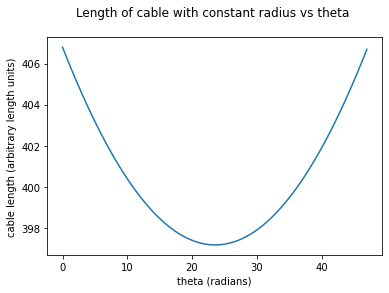

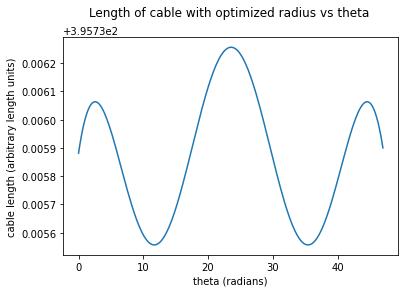

In [15]:
# Evaluate the results

subs = {
    P: _P,
    H: _H,
    theta_max: _theta_max,
    r_pulley: _r_pulley   
    }

# Create a bunch of sympy lambda functions.
# If we use sympy.subs instead of lambda functions, this cell takes multiple seconds.
dLwinch1 = dL_parametric(winch1_with_r(R)).doit()
dLwinch1_lam = lambdify([theta, a], dLwinch1.subs(subs))
dLwinch2 = dL_parametric(winch2_with_r(R)).doit()
dLwinch2_lam = lambdify([theta, a], dLwinch2.subs(subs))
Lmiddle1_lam = lambdify([theta, a], Lmiddle1_with_r(R).subs(subs))
Lmiddle2_lam = lambdify([theta, a], Lmiddle2_with_r(R).subs(subs))
Larc1_lam = lambdify([theta, a], Larc1_with_r(R).subs(subs))
Larc2_lam = lambdify([theta, a], Larc2_with_r(R).subs(subs))
theta_range = np.arange(0, _theta_max, 0.2)

def compute_lengths_res(a_to_use):
    # Compute the lengths of each section of the cable, as theta is adjusted over its range
    # Returns a list of lists of each section. Sum together to get the total length.
    
    Lwinch1_res = np.array([scipy.integrate.quad(lambda x: dLwinch1_lam(x, a_to_use), 0, _theta)[0]
                            for _theta in theta_range])
    Lwinch2_res = np.array([scipy.integrate.quad(lambda x: dLwinch2_lam(x, a_to_use), 0, _theta_max - _theta)[0]
                            for _theta in theta_range])
    Lmiddle1_res = np.array([Lmiddle1_lam(_theta, a_to_use)
                             for _theta in theta_range])
    Lmiddle2_res = np.array([Lmiddle2_lam(_theta, a_to_use)
                             for _theta in theta_range])
    Larc1_res = np.array([Larc1_lam(_theta, a_to_use)
                             for _theta in theta_range])
    Larc2_res = np.array([Larc2_lam(_theta, a_to_use)
                             for _theta in theta_range])
    
    return np.array([Lmiddle1_res, Lmiddle2_res, Lwinch1_res, Lwinch2_res, Larc1_res, Larc2_res])


Ltotal_constantradius = np.sum(compute_lengths_res(a_0), axis=0)
Ltotal_res = np.sum(compute_lengths_res(res_x), axis=0)

print(f"Constant radius {a_0}:")
print(f"Change in length from 0 to {_theta_max:.2f}rad:   {np.max(Ltotal_constantradius) - np.min(Ltotal_constantradius)}\n")

print(f"Optimized radius {res_x}:")
print(f"Change in length from 0 to {_theta_max:.2f}rad:   {np.max(Ltotal_res) - np.min(Ltotal_res)}")

plt.close('Ltotal_constantradius')
plt.figure('Ltotal_constantradius')
plt.title('Length of cable with constant radius vs theta \n')
plt.xlabel('theta (radians)')
plt.ylabel('cable length (arbitrary length units)')
plt.plot(theta_range, Ltotal_constantradius)

plt.close('Ltotal_res')
plt.figure('Ltotal_res')
plt.title('Length of cable with optimized radius vs theta \n')
plt.xlabel('theta (radians)')
plt.ylabel('cable length (arbitrary length units)')
plt.plot(theta_range, Ltotal_res)